<a href="https://colab.research.google.com/github/Sim98B/TabularDataGeneration/blob/main/BrainTumor/BrainTumorConditionalImageGeneration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Brain Tumor Conditional Image Generation

# Index

1. [Libraries](#Libraries)
2. [Data Preparation](#Breast-Cancer-Data)
3. [A stronger model](#Wassesrstein-GAN-with-Gradient-Penalty)
4. [Are the data good enough?](#Data-Evaluation)
5. [Validation Protocol](#TOR-TS-protocol)
6. [Latent Evaluation](#Principal-Component-Analysis)
7. [Conclusion](#Conclusion)

In [1]:
import sys
import os
import shutil

import pandas as pd
import numpy as np
from scipy import stats
from scipy.stats import skew, kurtosis, iqr

import matplotlib.pyplot as plt
import seaborn as sns

from PIL import Image

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torchvision.utils as vutils

import random
from tqdm.auto import tqdm
import joblib

import warnings
warnings.filterwarnings('ignore')

In [2]:
!git clone https://github.com/Sim98B/TabularDataGeneration.git

sys.path.append("TabularDataGeneration")
import utils

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Actual device: {device}')

Cloning into 'TabularDataGeneration'...
remote: Enumerating objects: 4149, done.
remote: Counting objects: 100% (181/181), done.
remote: Compressing objects: 100% (140/140), done.
remote: Total 4149 (delta 96), reused 79 (delta 40), pack-reused 3968 (from 1)
Receiving objects: 100% (4149/4149), 165.89 MiB | 15.43 MiB/s, done.
Resolving deltas: 100% (527/527), done.
Actual device: cuda


In [24]:
tumor_mapping = {0: 'Clear', 1: 'Glioma', 2: 'Meningioma', 3: 'Pituitary'}
section_mapping = {0: 'Axial', 1: 'Coronal', 2: 'Sagittal'}

feature_dim = 64
BS = 64

class BrainTumorDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = []
        self.labels = []  # (tumor_type, section_type)

        tumor_types = sorted(os.listdir(root_dir))
        self.tumor_dict = {tumor: i for i, tumor in enumerate(tumor_types)}

        for tumor in tumor_types:
            tumor_path = os.path.join(root_dir, tumor)
            if not os.path.isdir(tumor_path):
                continue

            section_types = sorted(os.listdir(tumor_path))
            self.section_dict = {section: i for i, section in enumerate(section_types)}

            for section in section_types:
                section_path = os.path.join(tumor_path, section)
                if not os.path.isdir(section_path):
                    continue

                for img_name in os.listdir(section_path):
                    img_path = os.path.join(section_path, img_name)
                    if img_name.endswith(('.png', '.jpg', '.jpeg')):
                        self.image_paths.append(img_path)
                        self.labels.append((self.tumor_dict[tumor], self.section_dict[section]))
    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        tumor_label, section_label = self.labels[idx]

        image = Image.open(img_path).convert('L')

        if self.transform:
            image = self.transform(image)

        return image, (tumor_label, section_label)

transform = transforms.Compose([
    transforms.Resize((feature_dim, feature_dim)),
    transforms.ToTensor(),
    transforms.Normalize(mean = [0.5], std = [0.5])
])

dataset = BrainTumorDataset(root_dir = "TabularDataGeneration/BrainTumor/Data", transform = transform)
dataloader = DataLoader(dataset, batch_size = BS, shuffle = True)

for images, labels in dataloader:
    print(f"Batch: {images.shape}")
    print(f"Tumor Labels: {[tumor_mapping[int(i)] for i in labels[0]]}")
    print(f"Section Label: {[section_mapping[int(i)] for i in labels[1]]}")
    break

Batch: torch.Size([64, 1, 64, 64])
Tumor Labels: ['Pituitary', 'Pituitary', 'Glioma', 'Clear', 'Meningioma', 'Meningioma', 'Glioma', 'Meningioma', 'Meningioma', 'Pituitary', 'Pituitary', 'Meningioma', 'Clear', 'Meningioma', 'Pituitary', 'Pituitary', 'Glioma', 'Clear', 'Clear', 'Glioma', 'Glioma', 'Pituitary', 'Pituitary', 'Pituitary', 'Clear', 'Meningioma', 'Meningioma', 'Clear', 'Pituitary', 'Pituitary', 'Meningioma', 'Glioma', 'Pituitary', 'Glioma', 'Glioma', 'Meningioma', 'Meningioma', 'Clear', 'Glioma', 'Meningioma', 'Clear', 'Pituitary', 'Meningioma', 'Pituitary', 'Glioma', 'Meningioma', 'Pituitary', 'Glioma', 'Clear', 'Meningioma', 'Pituitary', 'Pituitary', 'Pituitary', 'Pituitary', 'Meningioma', 'Glioma', 'Pituitary', 'Meningioma', 'Meningioma', 'Clear', 'Meningioma', 'Clear', 'Pituitary', 'Meningioma']
Section Label: ['Axial', 'Axial', 'Coronal', 'Axial', 'Sagittal', 'Coronal', 'Sagittal', 'Axial', 'Axial', 'Axial', 'Coronal', 'Axial', 'Sagittal', 'Axial', 'Axial', 'Axial', 'Ax

1: Clear  Sagittal
2: Meningioma  Sagittal
3: Pituitary  Coronal
4: Pituitary  Sagittal
5: Pituitary  Sagittal
6: Pituitary  Coronal
7: Glioma  Axial
8: Glioma  Coronal
9: Glioma  Axial
10: Meningioma  Axial
11: Meningioma  Axial
12: Pituitary  Axial
13: Pituitary  Sagittal
14: Clear  Axial
15: Glioma  Coronal
16: Pituitary  Coronal
17: Glioma  Axial
18: Glioma  Sagittal
19: Glioma  Sagittal
20: Meningioma  Coronal
21: Pituitary  Sagittal
22: Glioma  Axial
23: Pituitary  Coronal
24: Clear  Sagittal
25: Glioma  Coronal
26: Glioma  Axial
27: Clear  Axial
28: Glioma  Sagittal
29: Pituitary  Sagittal
30: Pituitary  Coronal
31: Meningioma  Sagittal
32: Meningioma  Coronal
33: Meningioma  Sagittal
34: Pituitary  Coronal
35: Clear  Sagittal
36: Meningioma  Axial
37: Clear  Axial
38: Clear  Axial
39: Clear  Axial
40: Glioma  Coronal
41: Clear  Axial
42: Pituitary  Sagittal
43: Meningioma  Sagittal
44: Clear  Axial
45: Pituitary  Coronal
46: Pituitary  Axial
47: Glioma  Sagittal
48: Clear  Axia

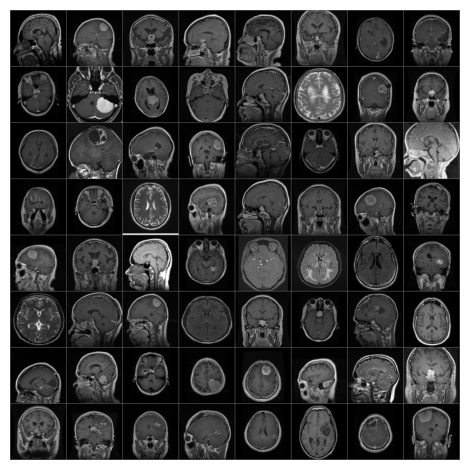

In [4]:
num_images = 64

dataiter = iter(dataloader)
images, labels = next(dataiter)

tumor_name = [tumor_mapping[int(i)] for i in labels[0][:num_images]]
section_name = [section_mapping[int(i)] for i in labels[1][:num_images]]
scan_name = [f"{tumor_name[i]}  {section_name[i]}" for i in range(len(tumor_name))]

for idx, label in enumerate(scan_name):
  print(f"{idx + 1}: {label}")
images = images[:num_images]
grid_img = vutils.make_grid(images, nrow = int(num_images ** 0.5), normalize = True, pad_value = 0.5)
#plt.figure(figsize = (int(num_images ** 0.5)*2.5,(int(num_images ** 0.5)*2.5)))
plt.imshow(grid_img.permute(1, 2, 0))
plt.axis("off")
plt.tight_layout();

In [5]:
class WCriticTinyVGG(nn.Module):
  def __init__(self, tumor_classes, section_classes, feature_dim):
        super(WCriticTinyVGG, self).__init__()

        self.Conv1 = nn.Sequential(
            nn.Conv2d(in_channels = 1, out_channels = 10, kernel_size = 3, stride = 1),
            nn.LeakyReLU(0.2),
            #nn.Dropout(0.3)
        )

        self.Conv2 = nn.Sequential(
            nn.Conv2d(in_channels = 10, out_channels = 10, kernel_size = 3, stride = 1),
            nn.LeakyReLU(0.2),
            nn.MaxPool2d(kernel_size = 2, stride = 2)
        )

        self.Conv3 = nn.Sequential(
            nn.Conv2d(in_channels = 10, out_channels = 10, kernel_size = 3, stride = 1),
            nn.LeakyReLU(0.2),
            #nn.Dropout(0.3)
        )

        self.Conv4 = nn.Sequential(
            nn.Conv2d(in_channels = 10, out_channels = 10, kernel_size = 3, stride = 1),
            nn.LeakyReLU(0.2),
            nn.MaxPool2d(kernel_size = 2, stride = 2)
        )

        self.fc_features = None

        self.fc_tumor = nn.Embedding(tumor_classes, feature_dim // 2)
        self.fc_section = nn.Embedding(section_classes, feature_dim // 2)

        self.fc_wasserstein = None

        self._initialize_fc(feature_dim)

  def _initialize_fc(self, feature_dim):
      with torch.no_grad():
          dummy = torch.randn(1, 1, feature_dim, feature_dim)
          out = self.Conv1(dummy)
          out = self.Conv2(out)
          out = self.Conv3(out)
          out = self.Conv4(out)
          flatten_dim = out.shape[1] * out.shape[2] * out.shape[3]
      self.fc_features = nn.Linear(flatten_dim, feature_dim)
      self.fc_wasserstein = nn.Linear(feature_dim * 2, 1)

  def forward(self, x, tumor_labels, section_labels):
    x = self.Conv1(x)
    x = self.Conv2(x)
    x = self.Conv3(x)
    x = self.Conv4(x)

    x = torch.flatten(x, start_dim = 1)
    x = self.fc_features(x)

    tumor_emb = self.fc_tumor(tumor_labels)
    section_emb = self.fc_section(section_labels)

    x = torch.cat((x, tumor_emb, section_emb), dim=1)

    x = self.fc_wasserstein(x)

    return x


class WGeneratorTinyVGG(nn.Module):
    def __init__(self, tumor_classes, section_classes, feature_dim, latent_dim = 100):
        super(WGeneratorTinyVGG, self).__init__()

        self.latent_dim = latent_dim

        self.fc_tumor = nn.Embedding(tumor_classes, feature_dim // 2)
        self.fc_section = nn.Embedding(section_classes, feature_dim // 2)

        self.fc_input = nn.Linear(latent_dim + feature_dim, 10 * 13 * 13)

        self.TConv1 = nn.Sequential(
            nn.ConvTranspose2d(in_channels = 10, out_channels = 10, kernel_size = 2, stride = 1),
            nn.LeakyReLU(0.2)
        )

        self.TConv2 = nn.Sequential(
            nn.ConvTranspose2d(in_channels = 10, out_channels = 10, kernel_size = 3, stride = 2, output_padding = 1),
            nn.LeakyReLU(0.2)
        )

        self.TConv3 = nn.Sequential(
            nn.ConvTranspose2d(in_channels = 10, out_channels = 10, kernel_size = 2, stride = 1),
            nn.LeakyReLU(0.2)
        )

        self.TConv4 = nn.Sequential(
            nn.ConvTranspose2d(in_channels = 10, out_channels = 1, kernel_size = 3, stride = 2, output_padding = 1),
            nn.Tanh()
        )

    def forward(self, z, tumor_labels, section_labels):
        tumor_emb = self.fc_tumor(tumor_labels)
        section_emb = self.fc_section(section_labels)

        x = torch.cat((z, tumor_emb, section_emb), dim = 1)
        x = self.fc_input(x)

        x = x.view(-1, 10, 13, 13)

        x = self.TConv1(x)
        x = self.TConv2(x)
        x = self.TConv3(x)
        x = self.TConv4(x)

        return x


utils.set_seed()
crit = WCriticTinyVGG(tumor_classes = len(tumor_mapping), section_classes = len(section_mapping), feature_dim = feature_dim)
gen = WGeneratorTinyVGG(tumor_classes = len(tumor_mapping), section_classes = len(section_mapping), feature_dim = feature_dim)
print(f"Critic output shape: {crit(images, labels[0], labels[1]).shape}")
print(f'Critic parameters: {sum(p.numel() for p in crit.parameters())/1000}k')
print(f"Generator output shape: {gen(torch.randn(BS, 100), labels[0], labels[1]).shape}")
print(f'Generator parameters: {sum(p.numel() for p in gen.parameters())/1000}k')

Critic output shape: torch.Size([64, 1])
Critic parameters: 9530.255k
Generator output shape: torch.Size([64, 1, 64, 64])
Generator parameters: 606.047k


In [18]:
def gradient_penalty(
    critic: torch.nn.Module,
    real_data: torch.Tensor,
    fake_data: torch.Tensor,
    tumor_labels: torch.Tensor,
    section_labels: torch.Tensor,
    lambda_gp: float = 10
):
    """
    Calculates the gradient penalty term for stabilizing WGAN-GP training.

    Args:
        critic (torch.nn.Module): The critic (discriminator) that evaluates real and generated data.
        real_data (torch.Tensor): Batch of real data with shape (batch_size, feature_dim).
        fake_data (torch.Tensor): Batch of generated data with shape (batch_size, feature_dim).
        tumor_labels (torch.Tensor): Tumor type labels.
        section_labels (torch.Tensor): Section type labels.
        lambda_gp (float, optional): Coefficient for the gradient penalty. Default: 10.

    Returns:
        torch.Tensor: Scaled gradient penalty value to be added to the critic's loss.
    """
    batch_size = real_data.size(0)
    device = real_data.device  # Assicuriamoci di operare sullo stesso device

    # Generiamo pesi casuali per l'interpolazione
    epsilon = torch.rand(batch_size, 1, 1, 1, device=real_data.device)  # Aggiungiamo dimensioni extra
    epsilon = epsilon.expand_as(real_data)  # Ora combacia con [batch_size, channels, height, width]

    # Interpoliamo tra real_data e fake_data
    interpolated = epsilon * real_data + (1 - epsilon) * fake_data
    interpolated.requires_grad_(True)

    # Calcoliamo il punteggio per i dati interpolati, passando entrambe le etichette
    interpolated_score = critic(interpolated, tumor_labels, section_labels)

    # Calcoliamo il gradiente
    grad_outputs = torch.ones_like(interpolated_score)
    gradients = torch.autograd.grad(
        outputs=interpolated_score,
        inputs=interpolated,
        grad_outputs=grad_outputs,
        create_graph=True,
        retain_graph=True,
        only_inputs=True
    )[0]

    # Calcoliamo la norma del gradiente e la penalità
    gradients_norm = gradients.view(batch_size, -1).norm(2, dim=1)
    penalty = lambda_gp * ((gradients_norm - 1) ** 2).mean()

    return penalty

def critic_loss(
    critic: torch.nn.Module,
    real_data: torch.Tensor,
    fake_data: torch.Tensor,
    tumor_labels: torch.Tensor,
    section_labels: torch.Tensor,
    lambda_gp: float = 10
):
    """
    Calculates the critic loss for a WGAN-GP, including the gradient penalty.

    Args:
        critic (torch.nn.Module): The critic (discriminator) that evaluates real and generated data.
        real_data (torch.Tensor): Batch of real data with shape (batch_size, feature_dim).
        fake_data (torch.Tensor): Batch of generated data with shape (batch_size, feature_dim).
        tumor_labels (torch.Tensor): Tumor type labels.
        section_labels (torch.Tensor): Section type labels.
        lambda_gp (float, optional): Coefficient for the gradient penalty. Default: 10.

    Returns:
        torch.Tensor: Scaled value of the critic's loss.
    """
    real_score = critic(real_data, tumor_labels, section_labels)
    fake_score = critic(fake_data, tumor_labels, section_labels)

    wasserstein_loss = fake_score.mean() - real_score.mean()

    gp = gradient_penalty(critic, real_data, fake_data, tumor_labels, section_labels, lambda_gp)
    return wasserstein_loss + gp

def generator_loss(critic: torch.nn.Module, fake_data: torch.Tensor, tumor_labels: torch.Tensor, section_labels: torch.Tensor):
    """
    Calculates the loss of the generator in a WGAN-GP for image generation.

    Args:
        critic (torch.nn.Module): The critic (discriminator) that evaluates real and generated data.
        fake_data (torch.Tensor): Batch of generated images with shape (batch_size, 1, H, W).
        tumor_labels (torch.Tensor): Tensor with tumor class labels.
        section_labels (torch.Tensor): Tensor with section class labels.

    Returns:
        torch.Tensor: Scaled value of the generator loss.
    """
    fake_score = critic(fake_data, tumor_labels, section_labels)
    return -fake_score.mean()

In [19]:
data = images
fake_data = gen(torch.randn(BS, 100), labels[0], labels[1]).detach().cpu()
print(critic_loss(crit, data, fake_data, labels[0], labels[1]))
print(generator_loss(crit, fake_data, labels[0], labels[1]))

tensor(9.8406, grad_fn=<AddBackward0>)
tensor(0.1828, grad_fn=<NegBackward0>)


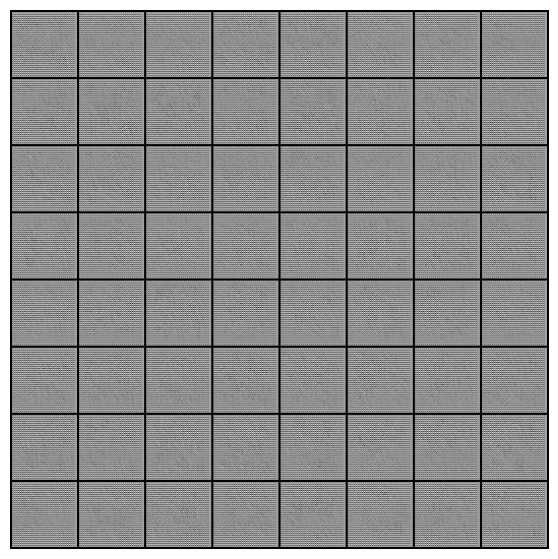

In [20]:
utils.set_seed()
noise = torch.randn(BS, 100)

tumor_labels = torch.randint(low = 0, high = 4, size = (BS,))
section_label = torch.randint(low = 0, high = 3, size = (BS,))
utils.generate_images(gen, noise, tumor_labels, section_label, BS)

In [21]:
load_pretrained = False
models_path = 'TabularDataGeneration/BrainTumor/Models/'

def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

if load_pretrained:
  print('Parameters loaded!')
  crit.load_state_dict(torch.load(models_path + "TinyVGGcritic.pth"))
  gen.load_state_dict(torch.load(models_path + "TinyVGGgenerator.pth"))
else:
  print('Parameters initialized')
  crit.apply(weights_init)
  gen.apply(weights_init)

g_lr = 5e-4
c_lr = 2e-3

g_opt = torch.optim.Adam(gen.parameters(), lr = g_lr, betas = (0.5, 0.999))
c_opt = torch.optim.RMSprop(crit.parameters(), lr = c_lr, weight_decay = 0)

utils.set_seed()
z = torch.randn(BS, 100)

fixed_tumor_labels = torch.randint(low = 0, high = 4, size = (BS,))
fixed_section_label = torch.randint(low = 0, high = 3, size = (BS,))

Parameters initialized


Training Model:   0%|          | 0/31 [00:00<?, ?it/s]

Epoch0/30 | CLoss: -20.0812 | GLoss: 29.7028


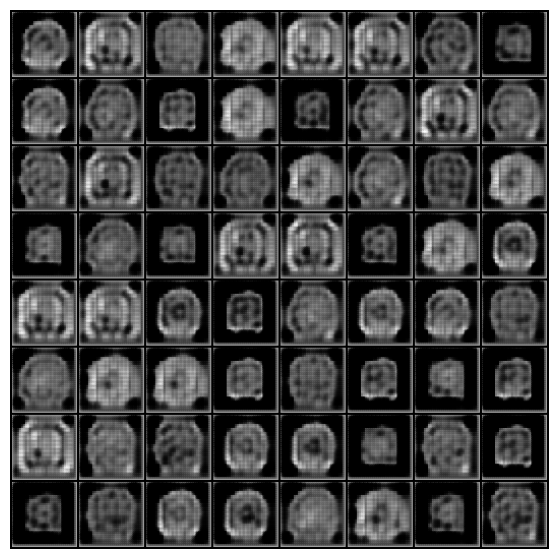

Epoch1/30 | CLoss: -18.9293 | GLoss: 28.2533
Epoch2/30 | CLoss: -18.1143 | GLoss: 30.1237
Epoch3/30 | CLoss: -17.4009 | GLoss: 35.0347


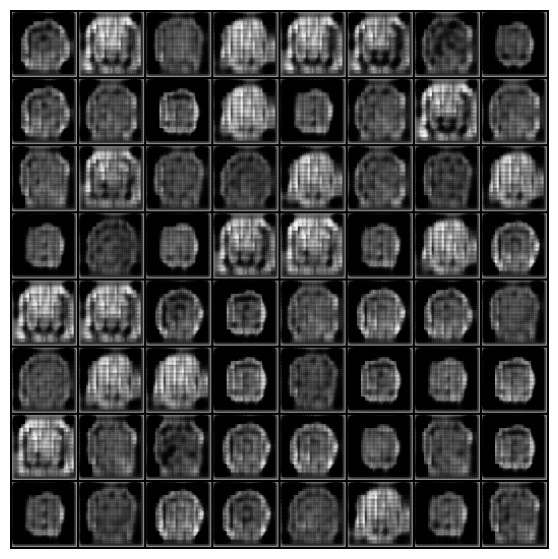

Epoch4/30 | CLoss: -16.5323 | GLoss: 32.9898
Epoch5/30 | CLoss: -16.1004 | GLoss: 30.5066
Epoch6/30 | CLoss: -15.9304 | GLoss: 32.3865


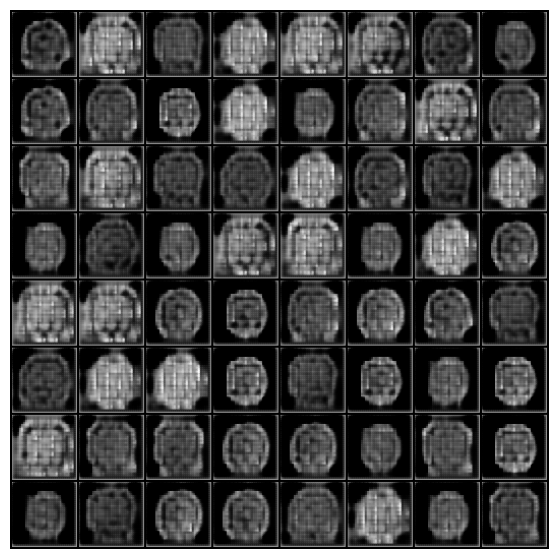

Epoch7/30 | CLoss: -15.4170 | GLoss: 25.3446
Epoch8/30 | CLoss: -15.2437 | GLoss: 24.1221


KeyboardInterrupt: 

In [23]:
epochs = 30
verbose = 0.1
noise_dim = 100

for epoch in tqdm(range(epochs + 1), desc = 'Training Model'):

  gen = gen.to(device)
  crit = crit.to(device)

  gen.train()
  crit.train()

  gen_epoch_loss = 0
  crit_epoch_loss = 0

  for batch_idx, (data, labels) in enumerate(dataloader):

    data = data.to(device)
    tumor_labels = labels[0].to(device)
    section_labels = labels[1].to(device)

    noise = torch.randn(data.shape[0], noise_dim).to(device)
    fake_data = gen(noise, tumor_labels, section_labels)

    c_opt.zero_grad()
    crit_loss = critic_loss(crit, data, fake_data, tumor_labels, section_labels)
    crit_epoch_loss += crit_loss.item()
    crit_loss.backward()
    c_opt.step()

  #if batch_idx % 2 == 0:

    noise = torch.randn(data.shape[0], noise_dim).to(device)
    fake_data = gen(noise, tumor_labels, section_labels)

    g_opt.zero_grad()
    gen_loss = generator_loss(crit, fake_data, tumor_labels, section_labels)
    gen_epoch_loss += gen_loss.item()
    gen_loss.backward()
    g_opt.step()

  g_epoch_loss = gen_epoch_loss/len(dataloader)
  c_epoch_loss = crit_epoch_loss/len(dataloader)
  print(f"Epoch{epoch}/{epochs} | CLoss: {c_epoch_loss:.4f} | GLoss: {g_epoch_loss:.4f}")

  if epoch % (epochs * 0.1) == 0 or epoch == epochs:
    #print(f"Epoch{epoch}/{epochs} | CLoss: {c_epoch_loss:.4f} | GLoss: {g_epoch_loss:.4f}")
    utils.generate_images(gen, z, fixed_tumor_labels, fixed_section_label, BS)

In [ ]:
#torch.save(crit.state_dict(), "TinyVGGcritic.pth")
#torch.save(gen.state_dict(), "TinyVGGgenerator.pth")

In [25]:
feature_dim = 256
BS = 64

class BrainTumorDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = []
        self.labels = []  # (tumor_type, section_type)

        tumor_types = sorted(os.listdir(root_dir))
        self.tumor_dict = {tumor: i for i, tumor in enumerate(tumor_types)}

        for tumor in tumor_types:
            tumor_path = os.path.join(root_dir, tumor)
            if not os.path.isdir(tumor_path):
                continue

            section_types = sorted(os.listdir(tumor_path))
            self.section_dict = {section: i for i, section in enumerate(section_types)}

            for section in section_types:
                section_path = os.path.join(tumor_path, section)
                if not os.path.isdir(section_path):
                    continue

                for img_name in os.listdir(section_path):
                    img_path = os.path.join(section_path, img_name)
                    if img_name.endswith(('.png', '.jpg', '.jpeg')):
                        self.image_paths.append(img_path)
                        self.labels.append((self.tumor_dict[tumor], self.section_dict[section]))
    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        tumor_label, section_label = self.labels[idx]

        image = Image.open(img_path).convert('L')

        if self.transform:
            image = self.transform(image)

        return image, (tumor_label, section_label)

transform = transforms.Compose([
    transforms.Resize((feature_dim, feature_dim)),
    transforms.ToTensor(),
    transforms.Normalize(mean = [0.5], std = [0.5])
])

dataset = BrainTumorDataset(root_dir = "TabularDataGeneration/BrainTumor/Data", transform = transform)
dataloader = DataLoader(dataset, batch_size = BS, shuffle = True)

for images, labels in dataloader:
    print(f"Batch: {images.shape}")
    print(f"Tumor Labels: {[tumor_mapping[int(i)] for i in labels[0]]}")
    print(f"Section Label: {[section_mapping[int(i)] for i in labels[1]]}")
    break

Batch: torch.Size([64, 1, 256, 256])
Tumor Labels: ['Meningioma', 'Meningioma', 'Meningioma', 'Pituitary', 'Meningioma', 'Pituitary', 'Glioma', 'Meningioma', 'Meningioma', 'Pituitary', 'Pituitary', 'Glioma', 'Meningioma', 'Meningioma', 'Meningioma', 'Clear', 'Glioma', 'Meningioma', 'Meningioma', 'Clear', 'Pituitary', 'Pituitary', 'Meningioma', 'Meningioma', 'Glioma', 'Pituitary', 'Pituitary', 'Meningioma', 'Glioma', 'Glioma', 'Glioma', 'Clear', 'Meningioma', 'Meningioma', 'Glioma', 'Pituitary', 'Glioma', 'Meningioma', 'Clear', 'Meningioma', 'Clear', 'Pituitary', 'Pituitary', 'Glioma', 'Glioma', 'Meningioma', 'Meningioma', 'Meningioma', 'Meningioma', 'Clear', 'Clear', 'Pituitary', 'Clear', 'Pituitary', 'Meningioma', 'Glioma', 'Pituitary', 'Glioma', 'Clear', 'Glioma', 'Pituitary', 'Pituitary', 'Meningioma', 'Pituitary']
Section Label: ['Sagittal', 'Coronal', 'Sagittal', 'Coronal', 'Coronal', 'Sagittal', 'Sagittal', 'Coronal', 'Axial', 'Axial', 'Sagittal', 'Axial', 'Coronal', 'Sagittal', 

In [34]:
latent_dim = 256
img_channels = 1
img_size = 256
n_classes_tumor = 4
n_classes_section = 3
batch_size = 64
gp_weight = 10
n_critic = 5

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        self.label_emb_tumor = nn.Embedding(n_classes_tumor, latent_dim)
        self.label_emb_section = nn.Embedding(n_classes_section, latent_dim)

        self.init_size = img_size // 32
        self.fc = nn.Linear(latent_dim, 512 * self.init_size**2)

        self.conv_blocks = nn.Sequential(
            nn.BatchNorm2d(512),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(512, 512, 3, padding=1),
            nn.BatchNorm2d(512, 0.8),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Upsample(scale_factor=2),
            nn.Conv2d(512, 256, 3, padding=1),
            nn.BatchNorm2d(256, 0.8),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Upsample(scale_factor=2),
            nn.Conv2d(256, 128, 3, padding=1),
            nn.BatchNorm2d(128, 0.8),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 64, 3, padding=1),
            nn.BatchNorm2d(64, 0.8),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Upsample(scale_factor=2),
            nn.Conv2d(64, img_channels, 3, padding=1),
            nn.Tanh()
        )

    def forward(self, noise, labels_tumor, labels_section):
        emb_tumor = self.label_emb_tumor(labels_tumor)
        emb_section = self.label_emb_section(labels_section)
        combined_emb = emb_tumor + emb_section

        gen_input = torch.mul(combined_emb, noise)
        out = self.fc(gen_input)
        out = out.view(out.shape[0], 512, self.init_size, self.init_size)
        img = self.conv_blocks(out)
        return img

class Critic(nn.Module):
    def __init__(self):
        super(Critic, self).__init__()

        self.label_emb_tumor = nn.Embedding(n_classes_tumor, 1)
        self.label_emb_section = nn.Embedding(n_classes_section, 1)
        self.img_size = img_size

        def critic_block(in_filters, out_filters, bn=True):
            block = [nn.Conv2d(in_filters, out_filters, 3, 2, 1)]
            if bn:
                block.append(nn.InstanceNorm2d(out_filters))
            block.append(nn.LeakyReLU(0.2, inplace=True))
            return block

        self.model = nn.Sequential(
            *critic_block(img_channels + 2, 64, bn=False),
            *critic_block(64, 128),
            *critic_block(128, 256),
            *critic_block(256, 512),
            nn.AdaptiveAvgPool2d(1)
        )

        self.validity = nn.Linear(512, 1)

    def forward(self, img, labels_tumor, labels_section):
        labels_tumor = self.label_emb_tumor(labels_tumor).unsqueeze(-1).unsqueeze(-1)
        labels_tumor = labels_tumor.repeat(1, 1, self.img_size, self.img_size)

        labels_section = self.label_emb_section(labels_section).unsqueeze(-1).unsqueeze(-1)
        labels_section = labels_section.repeat(1, 1, self.img_size, self.img_size)

        x = torch.cat([img, labels_tumor, labels_section], dim=1)
        out = self.model(x)
        out = out.view(out.shape[0], -1)
        validity = self.validity(out)
        return validity

utils.set_seed()
crit = Critic()
gen = Generator()
print(f"Critic output shape: {crit(images, labels[0], labels[1]).shape}")
print(f'Critic parameters: {sum(p.numel() for p in crit.parameters())/1000000:.3f} mln')
print(f"Generator output shape: {gen(torch.randn(BS, 256), labels[0], labels[1]).shape}")
print(f'Generator parameters: {sum(p.numel() for p in gen.parameters())/1000000:.3f} mln')

Critic output shape: torch.Size([64, 1])
Critic parameters: 1.551 mln
Generator output shape: torch.Size([64, 1, 256, 256])
Generator parameters: 12.335 mln


In [35]:
def compute_gradient_penalty(critic, real_samples, fake_samples, real_labels_tumor, real_labels_section):

    device = real_samples.device

    alpha = torch.rand(real_samples.size(0), 1, 1, 1, device=device)

    interpolates = (alpha * real_samples + ((1 - alpha) * fake_samples)).requires_grad_(True)

    d_interpolates = critic(interpolates, real_labels_tumor, real_labels_section)

    gradients = torch.autograd.grad(
        outputs=d_interpolates,
        inputs=interpolates,
        grad_outputs=torch.ones_like(d_interpolates),
        create_graph=True,
        retain_graph=True,
        only_inputs=True,
    )[0]

    # Calcola la penalità del gradiente
    gradients = gradients.view(gradients.size(0), -1)
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
    return gradient_penalty

In [36]:
g_lr = 5e-4
c_lr = 2e-3

g_opt = torch.optim.Adam(gen.parameters(), lr = g_lr, betas = (0.5, 0.999))
c_opt = torch.optim.RMSprop(crit.parameters(), lr = c_lr, weight_decay = 0)

utils.set_seed()
fixed_z = torch.randn(BS, 256)

fixed_tumor_labels = torch.randint(low = 0, high = 4, size = (BS,))
fixed_section_label = torch.randint(low = 0, high = 3, size = (BS,))

gen.to(device)
crit.to(device)

Critic(
  (label_emb_tumor): Embedding(4, 1)
  (label_emb_section): Embedding(3, 1)
  (model): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (6): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (9): InstanceNorm2d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): AdaptiveAvgPool2d(output_size=1)
  )
  (validity): Linear(in_features=512, out_fe

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

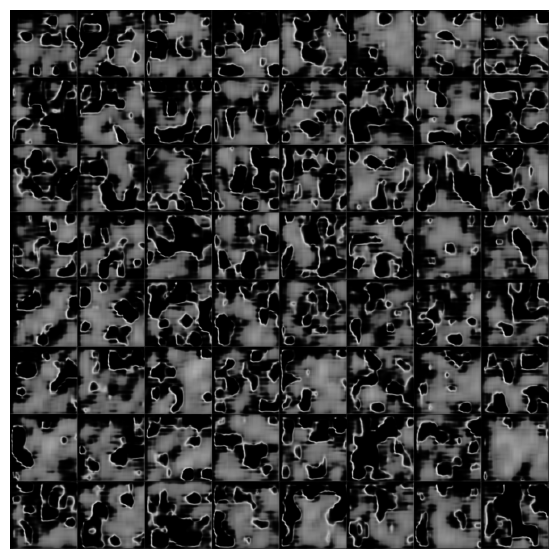

Epoch0/10 | CLoss: -23.8474 | GLoss: -3.5222


  0%|          | 0/51 [00:00<?, ?it/s]

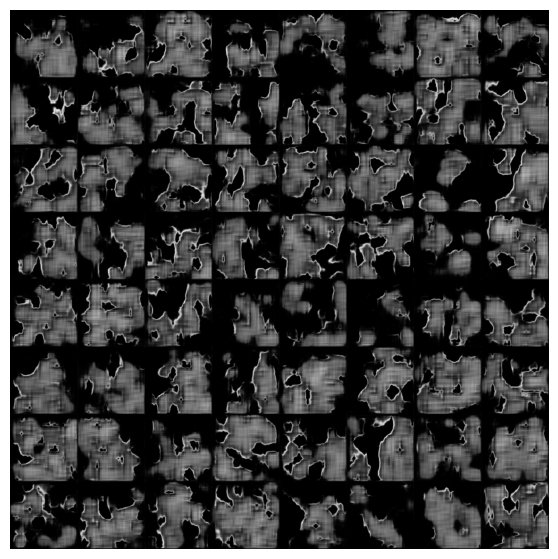

Epoch1/10 | CLoss: -88.5335 | GLoss: -5.9169


  0%|          | 0/51 [00:00<?, ?it/s]

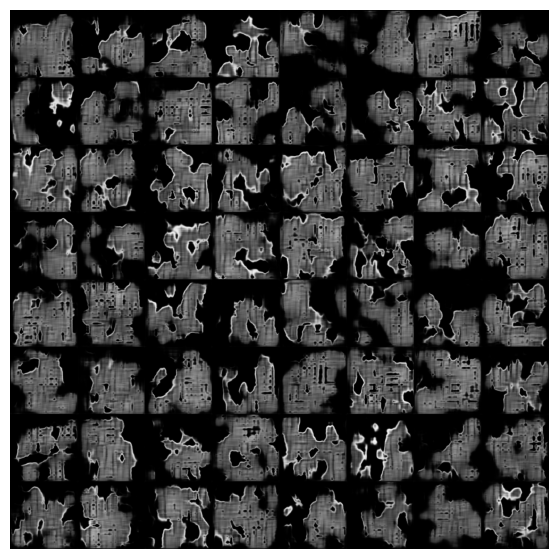

Epoch2/10 | CLoss: -146.1622 | GLoss: -7.8813


  0%|          | 0/51 [00:00<?, ?it/s]

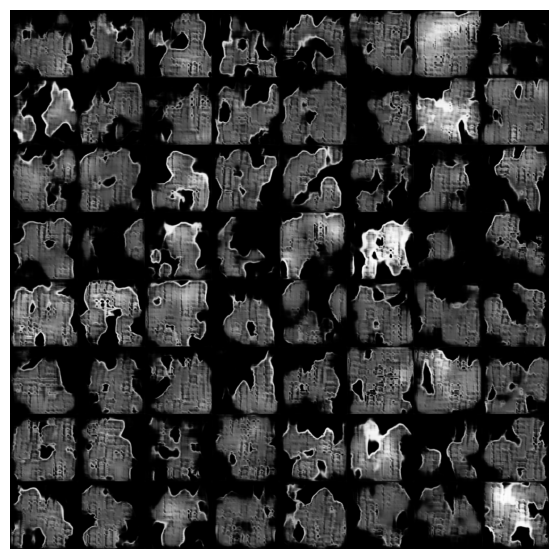

Epoch3/10 | CLoss: -174.2771 | GLoss: -16.1495


  0%|          | 0/51 [00:00<?, ?it/s]

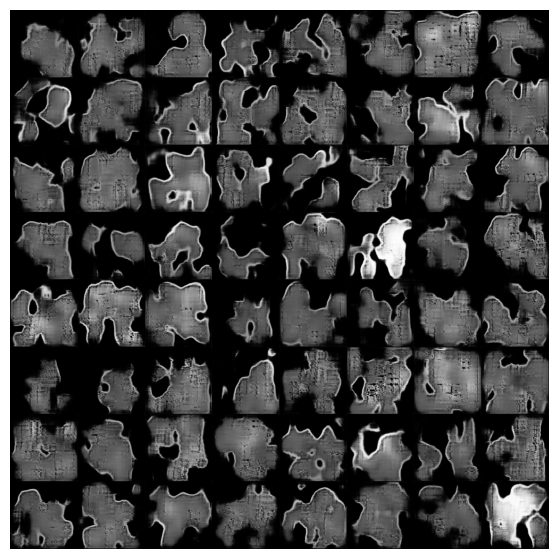

Epoch4/10 | CLoss: -188.8592 | GLoss: -22.7727


  0%|          | 0/51 [00:00<?, ?it/s]

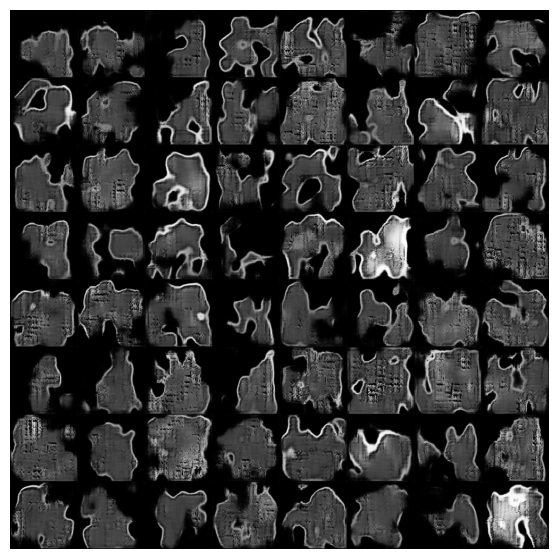

Epoch5/10 | CLoss: -195.6213 | GLoss: -41.4719


  0%|          | 0/51 [00:00<?, ?it/s]

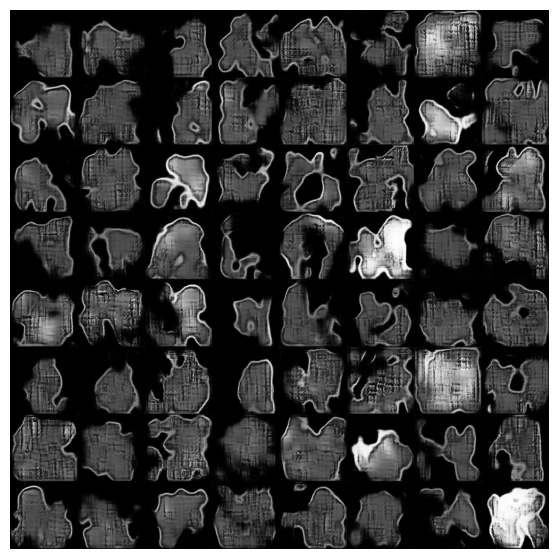

Epoch6/10 | CLoss: -210.3526 | GLoss: -45.1017


  0%|          | 0/51 [00:00<?, ?it/s]

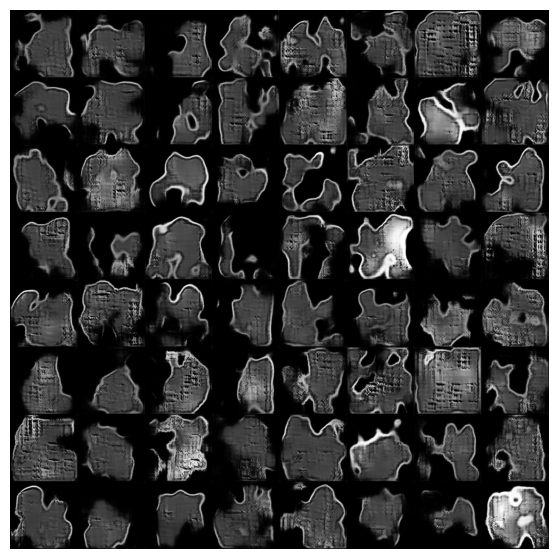

Epoch7/10 | CLoss: -226.4591 | GLoss: -54.7151


  0%|          | 0/51 [00:00<?, ?it/s]

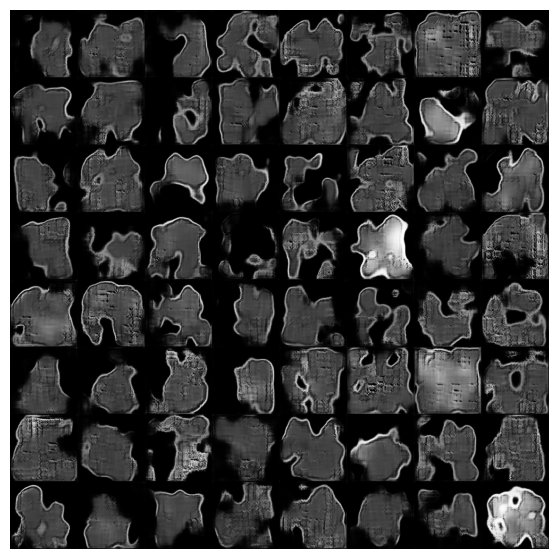

Epoch8/10 | CLoss: -247.3466 | GLoss: -65.0831


  0%|          | 0/51 [00:00<?, ?it/s]

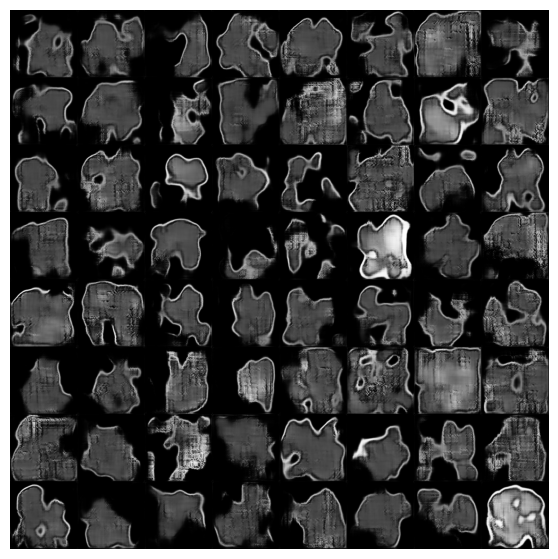

Epoch9/10 | CLoss: -262.5378 | GLoss: -70.9375


In [37]:
epochs = 10

for epoch in tqdm(range(epochs)):

  gen_epoch_loss = 0
  crit_epoch_loss = 0

  gen.train()
  crit.train()

  for i, (imgs, labels) in enumerate(tqdm(dataloader)):  # Nuova struttura dei dati

      # Train Critic
    for _ in range(n_critic):
      c_opt.zero_grad()

            # Campioni reali
      real_imgs = imgs.to(device)
      real_tumor = labels[0].to(device)
      real_section = labels[1].to(device)

            # Campioni fake
      z = torch.randn(imgs.size(0), latent_dim).to(device)
      fake_tumor = torch.randint(0, n_classes_tumor, (imgs.size(0),)).to(device)
      fake_section = torch.randint(0, n_classes_section, (imgs.size(0),)).to(device)
      fake_imgs = gen(z, fake_tumor, fake_section).to(device)

            # Calcolo delle loss
      real_validity = crit(real_imgs, real_tumor, real_section)
      fake_validity = crit(fake_imgs.detach(), fake_tumor, fake_section)
      gradient_penalty = compute_gradient_penalty(crit, real_imgs.data, fake_imgs.data, real_tumor, real_section)

      loss_C = -torch.mean(real_validity) + torch.mean(fake_validity) + gp_weight * gradient_penalty
      crit_epoch_loss += loss_C.item()
      loss_C.backward()
      c_opt.step()

        # Train Generator
    g_opt.zero_grad()

    z = torch.randn(imgs.size(0), latent_dim).to(device)
    fake_tumor = torch.randint(0, n_classes_tumor, (imgs.size(0),)).to(device)
    fake_section = torch.randint(0, n_classes_section, (imgs.size(0),)).to(device)
    gen_imgs = gen(z, fake_tumor, fake_section)
    gen_validity = crit(gen_imgs, fake_tumor, fake_section)
    loss_G = -torch.mean(gen_validity)
    gen_epoch_loss += loss_G.item()
    loss_G.backward()
    g_opt.step()

  utils.generate_images(gen, fixed_z, fixed_tumor_labels, fixed_section_label, BS)
  g_epoch_loss = gen_epoch_loss/len(dataloader)
  c_epoch_loss = crit_epoch_loss/len(dataloader)
  print(f"Epoch{epoch}/{epochs} | CLoss: {c_epoch_loss:.4f} | GLoss: {g_epoch_loss:.4f}")

In [38]:
torch.save(crit.state_dict(), "BigCritic.pth")
torch.save(gen.state_dict(), "BigGenerator.pth")